In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, regularizers

In [2]:
data = pd.read_csv('hotel_bookings.csv')

In [3]:
data_cln = data.fillna({'children': 0.0, 'country': 'Unknown', 'agent':0, 'company': 0})

In [4]:
data_cln['meal'].replace('Undefined', 'SC', inplace = True)

In [5]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, auc

In [6]:
resort_data = data_cln[data_cln.hotel == 'Resort Hotel']

In [7]:
city_data = data_cln[data_cln.hotel == 'City Hotel']

In [8]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"] # hotel

# Separate features and predicted value
features = num_features + cat_features

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

total hotel

In [9]:
# 10 fold
kfolds = 10 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

X = data_cln.drop(["is_canceled"], axis=1)[features]
y = data_cln["is_canceled"].to_numpy()

X = preprocessor.fit_transform(X)

result = []

for train_index, test_index in split.split(y):
    train_x = X[train_index]
    train_y = y[train_index]
    
    test_x = X[test_index]
    test_y = y[test_index]
    
    model = Lasso(random_state=42)
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})

In [10]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)    
    p_val = np.zeros(pred.shape)
    p_val[pred > 0.5] = 1
    total_accuracy.append(accuracy_score(test, p_val))
    total_f1.append(f1_score(test, p_val))
    total_pre.append(precision_score(test, p_val))
    total_recall.append(recall_score(test, p_val)) 

In [11]:
total_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [43]:
# total
for k, v in total_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.6842146075449272 0.6959222785396124 0.6904024417273705
acc 	 0.658179076974621 0.6719993299271296 0.6645028896892538
f1 	 0.35767939907303814 0.37796741660201705 0.3671789981038642
pre 	 0.5923769190047644 0.6297828335056876 0.6092579682545415
recall 	 0.25515695067264577 0.27162435407773533 0.262798298540523


resort hotel

In [13]:
# 10 fold
kfolds = 10 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

X = resort_data.drop(["is_canceled"], axis=1)[features]
y = resort_data["is_canceled"].to_numpy()

X = preprocessor.fit_transform(X)

result = []

for train_index, test_index in split.split(y):
    train_x = X[train_index]
    train_y = y[train_index]
    
    test_x = X[test_index]
    test_y = y[test_index]
    
    model = Lasso(random_state=42)
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})

In [14]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)
    p_val = np.zeros(pred.shape)
    p_val[pred > 0.5] = 1
    total_accuracy.append(accuracy_score(test, p_val))
    total_f1.append(f1_score(test, p_val))
    total_pre.append(precision_score(test, p_val))
    total_recall.append(recall_score(test, p_val)) 

In [15]:
resort_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [16]:
# resort
for k, v in resort_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.6580699966021066 0.6980233539498739 0.6775284114971885
acc 	 0.7076884672990514 0.7294058911632552 0.7222166749875187
f1 	 0.06080525883319639 0.10264900662251655 0.07847176136741252
pre 	 0.4157303370786517 0.6019417475728155 0.4996798027487161
recall 	 0.03280141843971631 0.056108597285067875 0.04264109443396823


city hotel

In [17]:
# 10 fold
kfolds = 10 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

X = city_data.drop(["is_canceled"], axis=1)[features]
y = city_data["is_canceled"].to_numpy()

X = preprocessor.fit_transform(X)

result = []

for train_index, test_index in split.split(y):
    train_x = X[train_index]
    train_y = y[train_index]
    
    test_x = X[test_index]
    test_y = y[test_index]
    
    model = Lasso(random_state=42)
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})

In [18]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)   
    p_val = np.zeros(pred.shape)
    p_val[pred > 0.5] = 1
    total_accuracy.append(accuracy_score(test, p_val))
    total_f1.append(f1_score(test, p_val))
    total_pre.append(precision_score(test, p_val))
    total_recall.append(recall_score(test, p_val)) 

In [19]:
city_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [20]:
# city
for k, v in city_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.68078242481203 0.6988494449863389 0.6902608683092414
acc 	 0.6365813689650826 0.650447497794025 0.6445480902558931
f1 	 0.4418695993715633 0.4700936365373591 0.4507120308196626
pre 	 0.6199782844733985 0.6503613118399111 0.6343977308449759
recall 	 0.33977650256720027 0.37193831267009375 0.34959313328637387


resort to city

In [21]:
x = data_cln.drop(["is_canceled"], axis=1)[features]
y = data_cln["is_canceled"].to_numpy()

x = preprocessor.fit_transform(x)

train_x = x[data_cln.hotel == 'Resort Hotel']
train_y = y[data_cln.hotel == 'Resort Hotel']

test_x = x[data_cln.hotel == 'City Hotel']
test_y = y[data_cln.hotel == 'City Hotel']

result = []
for i in range(10):
    model = Lasso()
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})

In [22]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)   
    p_val = np.zeros(pred.shape)
    p_val[pred > 0.5] = 1
    total_accuracy.append(accuracy_score(test, p_val))
    total_f1.append(f1_score(test, p_val))
    total_pre.append(precision_score(test, p_val))
    total_recall.append(recall_score(test, p_val)) 

In [23]:
rc_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [24]:
# resort to city
for k, v in rc_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.687913867307035 0.687913867307035 0.687913867307035
acc 	 0.5937728475986386 0.5937728475986386 0.5937728475986386
f1 	 0.09334908845374747 0.09334908845374747 0.09334908845374747
pre 	 0.6793611793611793 0.6793611793611793 0.6793611793611793
recall 	 0.05011781765452238 0.05011781765452238 0.050117817654522376


city to resort

In [25]:
x = data_cln.drop(["is_canceled"], axis=1)[features]
y = data_cln["is_canceled"].to_numpy()

x = preprocessor.fit_transform(x)

test_x = x[data_cln.hotel == 'Resort Hotel']
test_y = y[data_cln.hotel == 'Resort Hotel']

train_x = x[data_cln.hotel == 'City Hotel']
train_y = y[data_cln.hotel == 'City Hotel']

result = []
for i in range(10):
    model = Lasso()
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})

In [26]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)   
    p_val = np.zeros(pred.shape)
    p_val[pred > 0.5] = 1
    total_accuracy.append(accuracy_score(test, p_val))
    total_f1.append(f1_score(test, p_val))
    total_pre.append(precision_score(test, p_val))
    total_recall.append(recall_score(test, p_val)) 

In [27]:
cr_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [28]:
# city to resort
for k, v in cr_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.6788563530568159 0.6788563530568159 0.6788563530568158
acc 	 0.6869196205691462 0.6869196205691462 0.6869196205691461
f1 	 0.35143241286585997 0.35143241286585997 0.35143241286586
pre 	 0.41358325219084713 0.41358325219084713 0.4135832521908471
recall 	 0.30552058982197444 0.30552058982197444 0.30552058982197444


In [29]:
acc_box = np.array([total_res['acc'], resort_res['acc'], city_res['acc'], rc_res['acc'], cr_res['acc']])
pre_box = np.array([total_res['pre'], resort_res['pre'], city_res['pre'], rc_res['pre'], cr_res['pre']])
rec_box = np.array([total_res['recall'], resort_res['recall'], city_res['recall'], rc_res['recall'], cr_res['recall']])
f1_box = np.array([total_res['f1'], resort_res['f1'], city_res['f1'], rc_res['f1'], cr_res['f1']])
auc_box = np.array([total_res['auc'], resort_res['auc'], city_res['auc'], rc_res['auc'], cr_res['auc']])

In [30]:
np.max(acc_box)

0.7294058911632552

In [31]:
np.min(acc_box)

0.5937728475986386

In [32]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:


In [33]:
acc_box.max()

0.7294058911632552

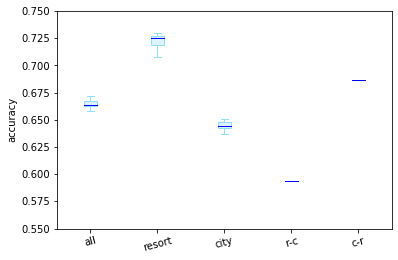

In [34]:

c= '#92DFF3'
f, axs = plt.subplots()

axs.boxplot(np.transpose(acc_box), showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs.set_ylim(0.55,0.75)
axs.set_xticklabels(['all', 'resort', 'city', 'r-c', 'c-r'],
                    rotation=15, fontsize=10)
axs.set_ylabel('accuracy')
plt.savefig('LassoAcc.png')

In [35]:
pre_box.min()

0.41358325219084713

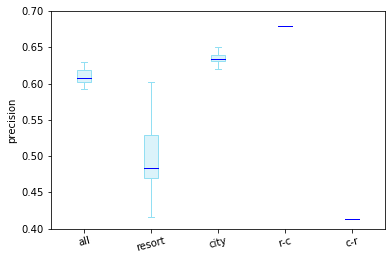

In [36]:

c= '#92DFF3'
f, axs = plt.subplots()

axs.boxplot(np.transpose(pre_box), showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs.set_ylim(0.4,0.7)
axs.set_xticklabels(['all', 'resort', 'city', 'r-c', 'c-r'],
                    rotation=15, fontsize=10)
axs.set_ylabel('precision')
plt.savefig('LassoPre.png')

In [37]:
rec_box.max()

0.37193831267009375

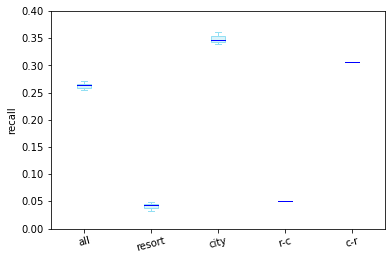

In [38]:
c= '#92DFF3'
f, axs = plt.subplots()

axs.boxplot(np.transpose(rec_box), showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs.set_ylim(0.0,0.4)
axs.set_xticklabels(['all', 'resort', 'city', 'r-c', 'c-r'],
                    rotation=15, fontsize=10)
axs.set_ylabel('recall')
plt.savefig('LassoRec.png')

In [39]:
f1_box.max()

0.4700936365373591

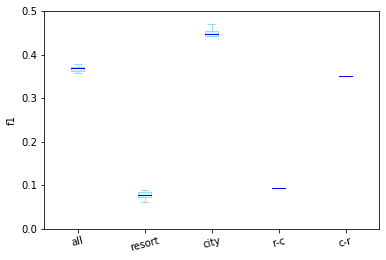

In [40]:

c= '#92DFF3'
f, axs = plt.subplots()

axs.boxplot(np.transpose(f1_box), showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs.set_ylim(0.0,0.5)
axs.set_xticklabels(['all', 'resort', 'city', 'r-c', 'c-r'],
                    rotation=15, fontsize=10)
axs.set_ylabel('f1')
plt.savefig('LassoF1.png')

In [41]:
auc_box.min()

0.6580699966021066

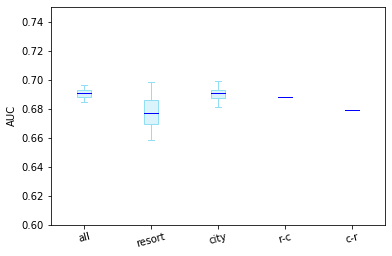

In [42]:

c= '#92DFF3'
f, axs = plt.subplots()

axs.boxplot(np.transpose(auc_box), showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs.set_ylim(0.60,0.75)
axs.set_xticklabels(['all', 'resort', 'city', 'r-c', 'c-r'],
                    rotation=15, fontsize=10)
axs.set_ylabel('AUC')
plt.savefig('LassoAUC.png')